<a href="https://colab.research.google.com/github/n0k0m3/rnn-mal-sentiment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><span style="font-size:6em"><b>Neural Networks</b></span></center>

***
<center><span style="font-size:2em"><b>Project 3</b></span></center>
<br>
<center><span style="font-size:2em"><b>Sentiment Analysis on MyAnimeList User Ratings</b></span></center>
<br>
<center><span style="font-size:1.5em"><b>Van Minh Nguyen  &   Tsz Chung Ho</b></span></center>

***

All data, codes and scripts can be obtained from [Github Repo](https://github.com/n0k0m3/rnn-mal-sentiment)

# Problem Statement

We perform Sentiment Analysis on user reviews from the website [MyAnimeList](https://myanimelist.net/). 

Users can review anime and assign scores ranging from 0-10 for 6 categories (story, animation, sound, character, enjoyment, overall).

We extracted review data using [Jikan REST API](https://github.com/jikan-me/jikan-rest) on our own server, and not the official MAL API (because it doesn't allow us to extract the reviews and scores which we need...).

We end up with a dataset consisting of about 60000 reviews. Each entry consists of a review plus the 6 aforementioned scores (so in effect we are doing multilabel classification).

We use the built-in TextVectorization method from keras to extract features for our classifier. 




# Data Collection and Preprocessing

## Jikan API - MAL crawler

Official MyAnimeList API doesn't offer the data we wanted: Review and Review Ratings from Users so we have to use an unofficial web crawler API.

Jikan API ([documentation](https://jikan.docs.apiary.io/#)) is an Unofficial MyAnimeList API, which crawl the webpage of MAL anime with specified ID and returns a json with all populated data on the website. Free hosted Jikan API has a rate limit of 1 request/ 4 seconds, which is not enough for the purpose of data collection. We have to host our own server and make a [script](https://github.com/n0k0m3/rnn-mal-sentiment/blob/main/jikan.py) to call the API to crawl.

We collected users' scores and reviews from the top 500 anime ranked by popularity and stored the data in a pandas DataFrame, saved in HDF5 format to use in notebook

Clip of data collection in process: https://streamable.com/7bq01q

## Data Preprocessing

After obtaining the review data, we converted the scores in each column to the classes 0 and 1 for negative ($\leq 5$) and positive ($\geq 7$). We set scores of 5 equal to null and then dropped rows which contained null entries.

As with most NLP problems, we vectorize the text entries to extract features for our classifiers. 
The process involves splitting the text into tokens and assigning an integer index for each token. 
In keras this is handled with the VectorTokenization class. 
We tried using n-grams as tokens as well; these allow us to use words of up to length n as individual tokens, which helps us capture more context information. 

After vectorizing the text, we used an embedding layer to turn words into vectors of fixed size, before feeding the word as input into the classifier. The parameters of the embedding layer can be learned from training. 

Since we used a linear Support Vector Machine for baseline comparisons, we also used sklearn's implementation of tf-idf (TfidfVectorizer) before passing the data into the SVM classifier. 
This method uses a vocabulary of words as well, but the idea is to assign weights on words according to how frequently they appear in a single document (proportional) vs multiple documents (inversely proportional). 

Lastly, we also tried using a Convolutional Network with word vectors obtained from word2vec (trained using GoogleNews dataset). 
Word2vec is an embedding method which, given a large set of text, constructs a vector space such that words embedded into that vector space are close if their contexts are similar. 
This word embedding is different from training the embedding layer in our LSTM network, since we are using pre-trained weights from the Google News dataset.

# Data Loading and Preparation

In [1]:
%%capture
!pip install -U tables
!apt-get update && apt-get install git-lfs
!git lfs clone https://github.com/n0k0m3/rnn-mal-sentiment
"""Restart Runtime NOW!"""

WARNING: Restart Runtime after running the 1st cell

In [2]:
%cd rnn-mal-sentiment
import pandas as pd
import numpy as np
import tensorflow as tf

/content/rnn-mal-sentiment


In [3]:
df = pd.read_hdf("data.h5")

In [4]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import zipfile

Convert score into sentiment label: Score of 7 and higher is considered positive, score of 5 and lower is considered negative

In [5]:
def sentiment_label(input):
  if input >= 7:
    return 1
  elif input <= 5:
    return 0
  else:
    return np.nan
df[df.columns[:-1]] = df[df.columns[:-1]].applymap(sentiment_label)
df = df.drop([0]).dropna()

If a data point has a NaN score, we'll drop the data. This reduced the amount of data point from 80000 to 60000. Now we proceed to split the dataset to Training | Validation | Testing sets with the ratio 80:10:10

In [6]:
X = df.pop("review")
Y = df.copy()
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.1)
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size = 0.1)

# Classification

We will be trying out other classifiers as a baseline. The classifier of choice here is SVM.

## Support Vector Machine (SVM)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(trainX)
test_vectors = vectorizer.transform(testX)

In [ ]:
# Trying out SVM 
from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(train_vectors, trainY["overall"])

prediction_linear = classifier_linear.predict(test_vectors)


# results

report = classification_report(testY["overall"], prediction_linear, output_dict=True)

SVM took 20-30 minutes to train and predict

In [ ]:
print(classification_report(testY["overall"], prediction_linear))

              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80       840
         1.0       0.96      0.98      0.97      5237

    accuracy                           0.95      6077
   macro avg       0.92      0.86      0.88      6077
weighted avg       0.95      0.95      0.95      6077



## Recurrent Neural Networks with Long-Short Term Memory (RNN with LSTM)

Without batching (batch = 1) it takes 9+ hours per epoch. Batching also allows us to increase vocabulary size and output length for the TextVectorization layer

In [7]:
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens=maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)
vectorizeLayer.adapt(trainX.values)

However, with preliminary testing, the higher the size of the vocabulary (`max_tokens`) and output sequence, the longer it takes for the model to converges. Further discretion is needed to hypertune this hyperparameter.

The data structure we'll be using is `tf.data.Dataset`. This method only creates a representation of the dataset and iteration happens in streaming fashion so full dataset doesn't need to be loaded into memory.

In [48]:
data_batch = 128

train = tf.data.Dataset.from_tensor_slices((trainX.values, trainY["overall"].values))
train = train.shuffle(len(train)).batch(data_batch)

val = tf.data.Dataset.from_tensor_slices((valX.values, valY["overall"].values))
val = val.shuffle(len(val)).batch(data_batch)

test = tf.data.Dataset.from_tensor_slices((testX.values, testY["overall"].values))
test = test.shuffle(len(test)).batch(data_batch)

In [96]:
class RNN_LSTM:
    def build(vectorizeLayer,classes):

      model = Sequential()

      model.add(Input(shape=(1,), dtype = 'string'))

      # add TextVectorization layer to the model
      model.add(vectorizeLayer)

      # add an embedding layer to turn integers into fixed-length vectors
      model.add(Embedding(maxTokens + 1, 128))

      # add a fully-connected recurrent layer
      model.add(LSTM(64))
      model.add(Dropout(0.5))

      # add a dense layer
      model.add(Dense(64, activation = 'relu'))
      model.add(Dropout(0.5))

      # add softmax classifier
      model.add(Dense(classes, activation = 'sigmoid'))

      return model

In [49]:
model_rnn = RNN_LSTM.build(vectorizeLayer,1)
model_rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_rnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_8 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [50]:
epochs = 10
history_rnn = model_rnn.fit(train, validation_data = val, epochs = epochs)

Epoch 1/10
385/385 [==============================] - 13s 34ms/step - loss: 0.3642 - accuracy: 0.8746 - val_loss: 0.3041 - val_accuracy: 0.8799
Epoch 2/10
385/385 [==============================] - 13s 33ms/step - loss: 0.2915 - accuracy: 0.8898 - val_loss: 0.2918 - val_accuracy: 0.8868
Epoch 3/10
385/385 [==============================] - 13s 33ms/step - loss: 0.2761 - accuracy: 0.8934 - val_loss: 0.3042 - val_accuracy: 0.8859
Epoch 4/10
385/385 [==============================] - 13s 33ms/step - loss: 0.2668 - accuracy: 0.8965 - val_loss: 0.2873 - val_accuracy: 0.8826
Epoch 5/10
385/385 [==============================] - 13s 33ms/step - loss: 0.2556 - accuracy: 0.9009 - val_loss: 0.3038 - val_accuracy: 0.8863
Epoch 6/10
385/385 [==============================] - 13s 33ms/step - loss: 0.2450 - accuracy: 0.9039 - val_loss: 0.3076 - val_accuracy: 0.8888
Epoch 7/10
385/385 [==============================] - 12s 32ms/step - loss: 0.2377 - accuracy: 0.9071 - val_loss: 0.2926 - val_accuracy:

Training Accuracy
              precision    recall  f1-score   support

         0.0       0.72      0.64      0.68      6231
         1.0       0.95      0.96      0.96     42988

    accuracy                           0.92     49219
   macro avg       0.83      0.80      0.82     49219
weighted avg       0.92      0.92      0.92     49219


Testing Accuracy
              precision    recall  f1-score   support

         0.0       0.54      0.49      0.51       775
         1.0       0.93      0.94      0.93      5302

    accuracy                           0.88      6077
   macro avg       0.74      0.71      0.72      6077
weighted avg       0.88      0.88      0.88      6077



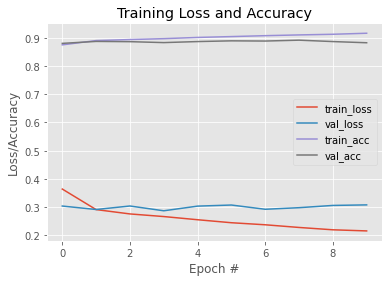

In [51]:
#  Plot the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history_rnn.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history_rnn.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history_rnn.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history_rnn.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

print("Training Accuracy")
predictedY = np.around(model_rnn.predict(trainX.values))
print(classification_report(trainY["overall"], predictedY))

print()
print("Testing Accuracy")
predictedY = np.around(model_rnn.predict(testX.values))
print(classification_report(testY["overall"], predictedY))

### Multilabel Classification

We'll now scale up the classification to all 6 labels, all binary label (Multi-label Binary classification)

In [56]:
data_batch = 128

train6 = tf.data.Dataset.from_tensor_slices((trainX.values, trainY.values))
train6 = train6.shuffle(len(train6)).batch(data_batch)

val6 = tf.data.Dataset.from_tensor_slices((valX.values, valY.values))
val6 = val6.shuffle(len(val6)).batch(data_batch)

test6 = tf.data.Dataset.from_tensor_slices((testX.values, testY.values))
test6 = test6.shuffle(len(test6)).batch(data_batch)

# Using the same TextVectorization Layer fitted before
model_rnn6 = RNN_LSTM.build(vectorizeLayer,6)
model_rnn6.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
model_rnn6.summary()

epochs = 20
history_rnn6 = model_rnn6.fit(train6, validation_data = val6, epochs = epochs)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_8 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 6)               

In [22]:
def plot_report(history,model):
  #  Plot the training loss and accuracy
  plt.style.use('ggplot')
  plt.figure()
  plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
  plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
  plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
  plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
      
  # add labels and legend
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss/Accuracy')
  plt.legend()

Training Accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96     42988
           1       0.92      0.98      0.95     40470
           2       0.94      0.96      0.95     43737
           3       0.94      0.96      0.95     43293
           4       0.92      0.98      0.95     40800
           5       0.93      0.98      0.95     41099

   micro avg       0.93      0.98      0.95    252387
   macro avg       0.93      0.98      0.95    252387
weighted avg       0.93      0.98      0.95    252387
 samples avg       0.85      0.89      0.85    252387


Testing Accuracy
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5302
           1       0.88      0.94      0.91      5003
           2       0.91      0.95      0.93      5380
           3       0.91      0.94      0.92      5341
           4       0.88      0.94      0.91      5034
           5       0.88      0.94      0.91      5084

   mi

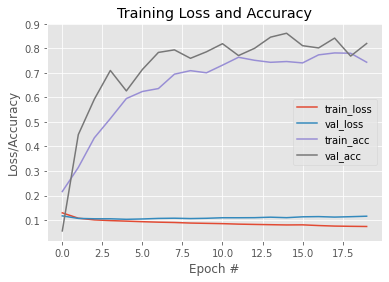

In [59]:
plot_report(history_rnn6,model_rnn6)

print("Training Accuracy")
predictedY = np.around(model_rnn6.predict(trainX.values))
print(classification_report(trainY, predictedY))

print()
print("Testing Accuracy")
predictedY = np.around(model_rnn6.predict(testX.values))
print(classification_report(testY, predictedY))

In [88]:
predictedY_df = pd.DataFrame(data=predictedY, columns=testY.columns)
# predictedY_df[(predictedY_df["overall"]==1) & (predictedY_df["story"]==0) & (predictedY_df["enjoyment"]==1)]
predictedY_df.iloc[1236]

overall      1.0
story        0.0
animation    1.0
sound        1.0
character    0.0
enjoyment    1.0
Name: 1236, dtype: float32

In [89]:
testY.iloc[1236]

overall      1.0
story        1.0
animation    1.0
sound        1.0
character    1.0
enjoyment    1.0
Name: 10882, dtype: float64

## Hyperparameter Tuning

### TextVectorization Layer tuning

TextVectorization is very important layer in LTSM since it converted the texts into tokens/int vectors that can be used in RNN. Different hyperparameters tuning will results in different classification result.

From preliminary testing, `max_tokens` (vocabulary size) and `output_sequence_length` are sensible and increasing these parameters will cause the model to converges slower. Considering the time taken to run 1 epoch (logs above), we decided to not tuning these hyperparameter.

#### Using TD-IDF output mode (Doesn't work)

In [90]:
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens=maxTokens,
                                   output_mode = 'tf-idf')
vectorizeLayer.adapt(trainX.values)

In [98]:
model_rnn_tfidf = RNN_LSTM.build(vectorizeLayer,6)
model_rnn_tfidf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_rnn_tfidf.summary()
epochs = 10
history_rnn6 = model_rnn_tfidf.fit(train6, validation_data = val6, epochs = epochs)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_9 (TextVe (None, 1000)              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 1000, 128)         128128    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 6)               

InvalidArgumentError: ignored

#### n_grams

In [99]:
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens=maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length=100,
                                   ngrams=2)
vectorizeLayer.adapt(trainX.values)

In [101]:
model_rnn_ngrams = RNN_LSTM.build(vectorizeLayer,6)
model_rnn_ngrams.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_rnn_ngrams.summary()
epochs = 20
history_rnn_ngrams = model_rnn_ngrams.fit(train6, validation_data = val6, epochs = epochs)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_10 (TextV (None, 100)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 100, 128)          128128    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 6)               

Training Accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95     42988
           1       0.89      0.98      0.93     40470
           2       0.90      0.99      0.94     43737
           3       0.90      0.98      0.94     43293
           4       0.90      0.98      0.94     40800
           5       0.90      0.98      0.94     41099

   micro avg       0.90      0.98      0.94    252387
   macro avg       0.90      0.98      0.94    252387
weighted avg       0.90      0.98      0.94    252387
 samples avg       0.86      0.91      0.87    252387


Testing Accuracy
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5302
           1       0.87      0.95      0.90      5003
           2       0.89      0.99      0.94      5380
           3       0.89      0.98      0.93      5341
           4       0.87      0.95      0.91      5034
           5       0.88      0.95      0.91      5084

   mi

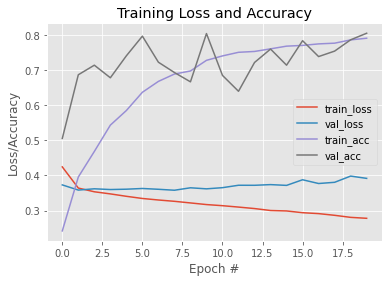

In [103]:
plot_report(history_rnn_ngrams,model_rnn_ngrams)

print("Training Accuracy")
predictedY = np.around(model_rnn6.predict(trainX.values))
print(classification_report(trainY, predictedY))

print()
print("Testing Accuracy")
predictedY = np.around(model_rnn6.predict(testX.values))
print(classification_report(testY, predictedY))

In [104]:
model_rnn6.save("models/rnn")
model_rnn_ngrams.save("models/rnn_ngrams")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/rnn/assets
INFO:tensorflow:Assets written to: models/rnn_ngrams/assets


## Convolutional Neural Network with Word2Vec

### Standard CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
class CNN:
  def build(vectorizeLayer,classes):
      # create a feedforward neural net
      model = Sequential()
      
      model.add(Input(shape=(1,), dtype = 'string'))
      
      # add TextVectorization layer to the model
      model.add(vectorizeLayer)

      # add an embedding layer to turn integers into fixed-length vectors
      model.add(Embedding(maxTokens + 1, 128))

      # add a convolutional layer with 32 1x5 filters and a 1x2 max pooling layer
      model.add(Conv1D(32, 5, padding = 'same'))
      model.add(Activation('relu'))
      model.add(MaxPooling1D(pool_size = 2))
      
      # add another convolutional layer with 64 1x5 filters and a 1x2 max pooling layer
      model.add(Conv1D(64, 5, padding= 'same'))
      model.add(Activation('relu'))
      model.add(MaxPooling1D(pool_size = 2))
      
      # add another convolutional layer
      model.add(Conv1D(128, 5, padding = 'same'))
      model.add(Activation('relu'))
      
      # add a fully-connected layer
      model.add(Flatten())
      model.add(Dense(500))
      model.add(Activation('relu'))
      
      # add a softmax classifier
      model.add(Dense(classes))
      model.add(Activation('softmax'))
      
      # return the constructed model
      return model

In [20]:
model_cnn = CNN.build(vectorizeLayer,6)
model_cnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_cnn.summary()
epochs = 10
history_cnn = model_cnn.fit(train6, validation_data = val6, epochs = epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 32)           20512     
_________________________________________________________________
activation_15 (Activation)   (None, 100, 32)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 64)            10304     
_________________________________________________________________
activation_16 (Activation)   (None, 50, 64)           

In [87]:
predictedY = model_cnn.predict(testX.values)

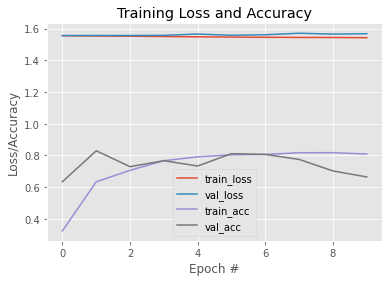

In [23]:
plot_report(history_cnn,model_cnn)

In [24]:
model_cnn.save("models/cnn")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cnn/assets


### CNN With Word2Vec embedding layer

In [129]:
!pip install gdown
!gdown https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
!gunzip GoogleNews-vectors-negative300.bin.gz

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/rnn-mal-sentiment/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:09, 170MB/s]


Loading Word2Vec weights correspending to TextVectorization layer's vocabulary

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

NUM_WORDS=1000
vocabulary_size=len(vectorizeLayer.get_vocabulary())+1

In [12]:
EMBEDDING_DIM=300
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word in vectorizeLayer.get_vocabulary():
  for i in range(vocabulary_size):
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

In [25]:
class CNN_Word2Vec:
  def build(vectorizeLayer,classes):
      # create a feedforward neural net
      model = Sequential()
      
      model.add(Input(shape=(1,), dtype = 'string'))
      
      # add TextVectorization layer to the model
      model.add(vectorizeLayer)

      # add an embedding layer to turn integers into fixed-length vectors
      model.add(Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True))

      # add a convolutional layer with 32 1x5 filters and a 1x2 max pooling layer
      model.add(Conv1D(32, 5, padding = 'same'))
      model.add(Activation('relu'))
      model.add(MaxPooling1D(pool_size = 2))
      
      # add another convolutional layer with 64 1x5 filters and a 1x2 max pooling layer
      model.add(Conv1D(64, 5, padding= 'same'))
      model.add(Activation('relu'))
      model.add(MaxPooling1D(pool_size = 2))
      
      # add another convolutional layer
      model.add(Conv1D(128, 5, padding = 'same'))
      model.add(Activation('relu'))
      
      # add a fully-connected layer
      model.add(Flatten())
      model.add(Dense(500))
      model.add(Activation('relu'))
      
      # add a softmax classifier
      model.add(Dense(classes))
      model.add(Activation('softmax'))
      
      # return the constructed model
      return model

In [27]:
model_cnn_w2v = CNN_Word2Vec.build(vectorizeLayer,6)
model_cnn_w2v.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_cnn_w2v.summary()
epochs = 10
history_cnn_w2v = model_cnn_w2v.fit(train6, validation_data = val6, epochs = epochs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          300300    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 100, 32)           48032     
_________________________________________________________________
activation_25 (Activation)   (None, 100, 32)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 50, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 50, 64)            10304     
_________________________________________________________________
activation_26 (Activation)   (None, 50, 64)           

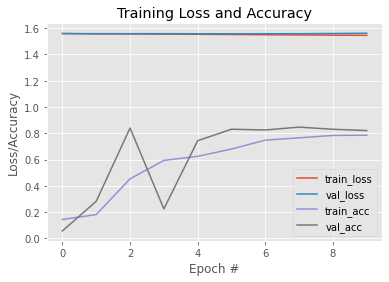

In [72]:
plot_report(history_cnn_w2v,model_cnn_w2v)

In [29]:
model_cnn_w2v.save("models/cnn_w2v")

INFO:tensorflow:Assets written to: models/cnn_w2v/assets


# Ensemble Model

In [74]:
from tensorflow.keras.models import load_model
import glob

# construct the path used to collect the models then initialize the
# models list
modelPaths = list(glob.glob("models/*"))
models = {}
print(modelPaths)

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
	print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
	models[modelPath.split("/")[1]]=load_model(modelPath)

['models/cnn', 'models/rnn_ngrams', 'models/cnn_w2v', 'models/rnn']
Loading model 1/4
Loading model 2/4
Loading model 3/4
Loading model 4/4


In [110]:
# initialize the list of predictions
print('Evaluating ensemble on Test set...')
predictions = []

def cnn_round(x):
  return (x > 0.15)*1

# loop over the models
for key,model in models.items():
  pred = model.predict(testX, batch_size=64)
	# use the current model to make predictions on the testing data,
	# then store these predictions in the aggregate predictions list
  if "cnn" in key:
    pred = cnn_round(pred)
  else:
    pred = np.around(pred)
  predictions.append(pred)
# average the probabilities across all model predictions, then show
# a classification report
prediction = np.average(predictions, axis=0)

Evaluating ensemble on Test set...


In [111]:
print("Testing Accuracy")
predictedY = np.around(prediction)
print(classification_report(testY, predictedY))

Testing Accuracy
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5301
           1       0.90      0.97      0.93      5016
           2       0.90      0.99      0.94      5404
           3       0.90      0.99      0.94      5342
           4       0.90      0.97      0.94      5046
           5       0.90      0.98      0.94      5087

   micro avg       0.90      0.98      0.94     31196
   macro avg       0.90      0.98      0.94     31196
weighted avg       0.90      0.98      0.94     31196
 samples avg       0.87      0.92      0.87     31196



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
